In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import math # For radians in rose plot
from matplotlib.colors import ListedColormap

from IPython.display import display
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from collections import Counter

import random
import subprocess
import json # Import json to load the stats file
import pandas as pd # Import pandas for DataFrame summary
from utilities import plot_fault_counts, plot_histogram, plot_rose_diagram, append_param_to_cmd, normalize, plot_fault_points, count_pixels   
from IPython.display import display
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import shutil

from cigvis.plotlyplot import create_overlay, plot3D   # <-- add this
from cigvis import colormap, config

import cigvis.plotlyplot as cgp
from cigvis.plotlyplot import create_slices, add_mask, plot3D
from cigvis import colormap, config

import os, json, random
import numpy as np
import cigvis.plotlyplot as cgp
from cigvis import colormap, config
from ipywidgets import IntSlider, Play, Button, HBox, VBox, interactive_output, jslink
from IPython.display import display

from scipy.ndimage import map_coordinates, binary_dilation, generate_binary_structure

from tqdm import trange

---

---

# Data Generation

In [ ]:
# 0)  User picks parameters ──────────────────────────────────────────────
mask_mode      = 0
num_pairs      = 200
train_split    = 200          # absolute counts
val_split      = 20

cube_size      = 128
ricker_freq    = (50, 70)
seismic_noise  = (0.1, 0.5)
ricker_dt      = 0.002
wavelet_len    = 0.2
num_gauss      = (2, 10)
num_faults     = (0, 4)
max_disp       = (-50, 50)

# ─────────────────────────────────────────────────────────────────────────
# CHOOSE ONE “strike_windows” line below and **comment-out** the others.
# The text must be in quotes -- it is passed to the script verbatim.
# ─────────────────────────────────────────────────────────────────────────
# strike_windows = "0-360"                 # full azimuth
# strike_windows = "40-50"                 # one narrow cone (≈ 45°)
# strike_windows = "40-50,220-230"         # two opposite cones (≈ 45° & 225°)
#strike_windows = "45-135,225-315"          # two half-circles (or "315-45,135-225")
strike_windows = "40-50,220-230,130-140,310-320"
# ─────────────────────────────────────────────────────────────────────────

dip            = (60, 70)
output_format  = "npy"


In [3]:
# explicit counts
num_train = int(train_split)
num_val   = int(val_split)

if num_train + num_val != num_pairs:
    raise ValueError(
        f"ERROR: train+val ({num_train + num_val}) "
        f"does not equal num_pairs ({num_pairs})."
    )
else:
    print(f"✔  Using {num_train} training and {num_val} validation cubes.")

✔  Using 100 training and 1 validation cubes.


In [4]:
# ───────────────────────────────────────────────────────────────
# 1)  ROOT directory – works in .py or notebook
# ───────────────────────────────────────────────────────────────
try:                                   # for plain-.py execution
    ROOT_DIR = os.path.dirname(os.path.abspath(__file__))
except NameError:                      # Jupyter / IPython
    ROOT_DIR = os.getcwd()

In [5]:
# ───────────────────────────────────────────────────────────────
# 2)  Centralised output locations  (⇦ NEW)
# ───────────────────────────────────────────────────────────────
DATA_DIR   = os.path.join(ROOT_DIR, "data")        # …/generateSynthData/data
STATS_DIR  = os.path.join(ROOT_DIR, "statistics")  # …/generateSynthData/statistics
IMAGE_DIR  = os.path.join(ROOT_DIR, "images")      # …/generateSynthData/images

# make sure they exist
for _d in (DATA_DIR, STATS_DIR, IMAGE_DIR):
    os.makedirs(_d, exist_ok=True)

In [6]:
def parse_windows(s):
    out = []
    for rng in s.split(','):
        lo, hi = map(lambda x: float(x.strip()), rng.split('-'))
        out.append((lo, hi))
    return out

In [7]:
# ─── call generator script ───────────────────────────────────────────────
script    = os.path.join(ROOT_DIR, "synthDataGeneration.py")
base_out  = DATA_DIR          # where the cubes will be written

# wipe previous run
for split in ("train", "validation"):
    shutil.rmtree(os.path.join(base_out, split), ignore_errors=True)

os.makedirs(base_out, exist_ok=True)

cmd = [
    "python", script,
    "--num-pairs", str(num_pairs),
    "--size",      str(cube_size),
    "--dt",        str(ricker_dt),
    "--length",    str(wavelet_len),
    "--mask-mode", str(mask_mode),
    "--format",    output_format,
    "--output-dir", base_out,
    "--train-split", str(train_split),
    "--val-split",   str(val_split),

    "--faults",   f"{num_faults[0]},{num_faults[1]}",
    f"--max-disp={max_disp[0]},{max_disp[1]}",

    "--strike",   strike_windows,
    "--dip",      f"{dip[0]},{dip[1]}",
    "--freq",     f"{ricker_freq[0]},{ricker_freq[1]}",
    "--num-gaussians", f"{num_gauss[0]},{num_gauss[1]}",
    "--noise",    f"{seismic_noise[0]},{seismic_noise[1]}",
    "--strike-sampling", "equal" # or "span" where “equal” = each window chosen with equal probability; “span” = proportional to angular width.
]

print(" ".join(cmd))
result = subprocess.run(cmd, text=True)

python /home/roderickperez/DS_PROJECTS/faultSeg/generateSynthData/synthDataGeneration.py --num-pairs 101 --size 128 --dt 0.002 --length 0.2 --mask-mode 1 --format npy --output-dir /home/roderickperez/DS_PROJECTS/faultSeg/generateSynthData/data --train-split 100 --val-split 1 --faults 0,4 --max-disp=-50,50 --strike 40-50,220-230,130-140,310-320 --dip 60,70 --freq 50,70 --num-gaussians 2,10 --noise 0.1,0.5 --strike-sampling equal

Data split: 100 train, 1 validation.
Output format: npy

Starting data generation for 101 pairs...


Generating Cubes:  99%|█████████▉| 100/101 [01:49<00:01,  1.15s/it]

[timings cube 0] fold 0.153s | shear 0.122s | faults 0.294s | conv 0.580s | post(noise+scale) 0.042s | save 0.012s

--- Saving Statistics Files ---
Saved full statistics to /home/roderickperez/DS_PROJECTS/faultSeg/generateSynthData/data/statistics_full.json
Saved train statistics to /home/roderickperez/DS_PROJECTS/faultSeg/generateSynthData/data/statistics_train.json
Saved validation statistics to /home/roderickperez/DS_PROJECTS/faultSeg/generateSynthData/data/statistics_validation.json

[2025-08-09 15:17:07] Generation complete.
 • train/seis/ → /home/roderickperez/DS_PROJECTS/faultSeg/generateSynthData/data/train/seis
 • train/fault/ → /home/roderickperez/DS_PROJECTS/faultSeg/generateSynthData/data/train/fault
 • validation/seis/ → /home/roderickperez/DS_PROJECTS/faultSeg/generateSynthData/data/validation/seis
 • validation/fault/ → /home/roderickperez/DS_PROJECTS/faultSeg/generateSynthData/data/validation/fault
Done ✅


Generating Cubes: 100%|██████████| 101/101 [01:50<00:00,  1.09s/it]


In [8]:
if result.returncode == 0:
    print("Data generation successful!")
    print(result.stdout)
else:
    print("Data generation failed.")
    print(result.stderr)

for fname in ("statistics_full.json",
              "statistics_train.json",
              "statistics_validation.json"):
    src = os.path.join(base_out, fname)
    dst = os.path.join(STATS_DIR, fname)
    if os.path.exists(src):
        try:
            os.replace(src, dst)          # move (overwrite if exists)
            print(f"Moved {fname} → {STATS_DIR}")
        except Exception as e:
            print(f"Could not move {fname}: {e}")
    else:
        print(f"Warning: {fname} not found in {base_out}")
        
# Data generation statistics
stats = {
    "total_pairs": num_pairs,
    "train_pairs": num_train,
    "validation_pairs": num_val,
}

# Save statistics to a JSON file
stats_file_path = os.path.join(STATS_DIR, "stats_data.json")
with open(stats_file_path, 'w') as f:
    json.dump(stats, f, indent=4)

print(f"Data generation complete. Statistics saved to {stats_file_path}")

Data generation successful!
None
Moved statistics_full.json → /home/roderickperez/DS_PROJECTS/faultSeg/generateSynthData/statistics
Moved statistics_train.json → /home/roderickperez/DS_PROJECTS/faultSeg/generateSynthData/statistics
Moved statistics_validation.json → /home/roderickperez/DS_PROJECTS/faultSeg/generateSynthData/statistics
Data generation complete. Statistics saved to /home/roderickperez/DS_PROJECTS/faultSeg/generateSynthData/statistics/stats_data.json


In [9]:
# ─── 2) Check the output ────────────────────────────────────────────────
# Check the total number of files created across all splits
total_files_generated = 0
for split in ['train', 'validation']:
    seis_dir = os.path.join(base_out, split, 'seis')
    if os.path.exists(seis_dir):
        total_files_generated += len(os.listdir(seis_dir))

if total_files_generated != num_pairs:
    print(f"\nWarning: Mismatch in generated files ({total_files_generated}) and requested pairs ({num_pairs}). Check script output.")
else:
    print(f"\nSuccessfully generated {total_files_generated} file pairs.")


Successfully generated 101 file pairs.


In [10]:
# Append parameters that can be fixed values or ranges
def append_param_to_cmd(cmd_list, arg_name, value):
    if value is not None:
        if isinstance(value, tuple):
            cmd_list += [f"--{arg_name}", f"{value[0]},{value[1]}"]
        else:
            cmd_list += [f"--{arg_name}", str(value)]

In [11]:
print("\nCommand to run:")
print(" ".join(cmd)) # type: ignore # Print the corrected command
print("\nRunning subprocess...")

# run and capture output
# check=False allows inspection of returncode without raising exception immediately
#result = subprocess.run(cmd, capture_output=True, text=True, check=False)
print("=== STDOUT ===\n", result.stdout)
print("=== STDERR ===\n", result.stderr)

if result.returncode != 0:
    print(f"Error: Script exited with return code {result.returncode}")
    # Optionally print more context or raise error
    # raise subprocess.CalledProcessError(result.returncode, cmd, output=result.stdout, stderr=result.stderr)
    # Exit this cell or notebook execution if script failed critically?
    # For now, just print error and continue, assuming stats file might still be partially saved
else:
    print("Script finished successfully.")

# Check if the expected number of files were generated
total_files_generated = 0
for split in ['train', 'validation']:
    seis_dir = os.path.join(base_out, split, 'seis')
    if os.path.exists(seis_dir):
        total_files_generated += len([f for f in os.listdir(seis_dir) if f.endswith((".npy", ".npz", ".dat"))])

if total_files_generated != num_pairs:
    print(f"\nWarning: Mismatch in generated files ({total_files_generated}) and requested pairs ({num_pairs}). Check script output.")
else:
    print(f"\nSuccessfully generated {total_files_generated} file pairs across all splits.")


Command to run:
python /home/roderickperez/DS_PROJECTS/faultSeg/generateSynthData/synthDataGeneration.py --num-pairs 101 --size 128 --dt 0.002 --length 0.2 --mask-mode 1 --format npy --output-dir /home/roderickperez/DS_PROJECTS/faultSeg/generateSynthData/data --train-split 100 --val-split 1 --faults 0,4 --max-disp=-50,50 --strike 40-50,220-230,130-140,310-320 --dip 60,70 --freq 50,70 --num-gaussians 2,10 --noise 0.1,0.5 --strike-sampling equal

Running subprocess...
=== STDOUT ===
 None
=== STDERR ===
 None
Script finished successfully.

Successfully generated 101 file pairs across all splits.


In [12]:
# ─── 2) Load generated data and statistics ───────────────────────────────────────────────────────

# Define the base output directory
#base_out = os.path.expanduser("/Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/output")

# Define the splits and their expected number of files
splits = {
    "train": num_train,
    "validation": num_val
}

# Check if the expected number of files were generated for each split
for split, expected_files in splits.items():
    seis_dir = os.path.join(base_out, split, "seis")
    fault_dir = os.path.join(base_out, split, "fault")

    if os.path.exists(seis_dir):
        files = sorted(f for f in os.listdir(seis_dir) if f.endswith((".npy", ".npz", ".dat")))
        n_files = len(files)
        if n_files != expected_files:
            print(f"Warning: Mismatch in generated files for '{split}' split. Expected {expected_files}, found {n_files} in {seis_dir}")
    else:
        print(f"Warning: Seismic output directory not found for '{split}' split: {seis_dir}")

    if not os.path.exists(fault_dir):
        print(f"Warning: Fault output directory not found for '{split}' split: {fault_dir}")

# Load the statistics files
stats_data = {}
for split in splits.keys():
    stats_file_path = os.path.join(STATS_DIR, f"statistics_{split}.json")
    if os.path.exists(stats_file_path):
        with open(stats_file_path, 'r') as f:
            stats_data[split] = json.load(f)
            print(f"Successfully loaded statistics for '{split}' split.")
    else:
        print(f"Warning: Statistics file not found for '{split}' split: {stats_file_path}")

# Load the full statistics file
full_stats_path = os.path.join(STATS_DIR, "statistics_full.json")
if os.path.exists(full_stats_path):
    with open(full_stats_path, 'r') as f:
        full_stats = json.load(f)
        print("Successfully loaded full statistics.")
else:
    print(f"Warning: Full statistics file not found: {full_stats_path}")

Successfully loaded statistics for 'train' split.
Successfully loaded statistics for 'validation' split.
Successfully loaded full statistics.


In [13]:
def in_windows(a, windows):
    a = a % 360.0
    for lo, hi in windows:
        lo, hi = lo % 360.0, hi % 360.0
        span = (hi - lo) % 360.0 or 360.0
        if (a - lo) % 360.0 <= span:
            return True
    return False

In [14]:
# --- Distribution of strikes across windows (full dataset) ---
wins = parse_windows(strike_windows)   # reuse the same string you passed to the script

def which_window(a):
    for i, w in enumerate(wins):
        if in_windows(a, [w]):         # reuse your in_windows()
            return i
    return None

cnt = Counter(which_window(fp['strike']) for fp in full_stats['all_fault_params'])
total = sum(cnt.values())

print("\nStrike counts per window (full):")
for i, (lo, hi) in enumerate(wins):
    n = cnt.get(i, 0)
    pct = 100.0 * n / total if total else 0.0
    print(f"  window {i}: {lo:.1f}–{hi:.1f}° → {n} ({pct:.1f}%)")
print("  total faults counted:", total)


Strike counts per window (full):
  window 0: 40.0–50.0° → 64 (29.0%)
  window 1: 220.0–230.0° → 61 (27.6%)
  window 2: 130.0–140.0° → 51 (23.1%)
  window 3: 310.0–320.0° → 45 (20.4%)
  total faults counted: 221


In [15]:
for split in ("train", "validation"):
    path = os.path.join(STATS_DIR, f"statistics_{split}.json")
    if not os.path.exists(path):
        continue
    with open(path) as f:
        s = json.load(f)
    cnt = Counter(which_window(fp['strike']) for fp in s['all_fault_params'])
    total = sum(cnt.values())
    print(f"\n[{split}] strike counts per window:")
    for i, (lo, hi) in enumerate(wins):
        n = cnt.get(i, 0)
        pct = 100.0 * n / total if total else 0.0
        print(f"  window {i}: {lo:.1f}–{hi:.1f}° → {n} ({pct:.1f}%)")



[train] strike counts per window:
  window 0: 40.0–50.0° → 63 (29.0%)
  window 1: 220.0–230.0° → 60 (27.6%)
  window 2: 130.0–140.0° → 50 (23.0%)
  window 3: 310.0–320.0° → 44 (20.3%)

[validation] strike counts per window:
  window 0: 40.0–50.0° → 1 (25.0%)
  window 1: 220.0–230.0° → 1 (25.0%)
  window 2: 130.0–140.0° → 1 (25.0%)
  window 3: 310.0–320.0° → 1 (25.0%)


In [16]:
mode_used = "equal"  # or "span"
if mode_used == "equal":
    expected = [1/len(wins)] * len(wins)
else:
    spans = [((hi - lo) % 360) or 360 for lo, hi in wins]
    s = sum(spans)
    expected = [sp/s for sp in spans]
print("\nExpected % per window:", [round(100*x, 1) for x in expected])



Expected % per window: [25.0, 25.0, 25.0, 25.0]


In [17]:
allowed = parse_windows(strike_windows)
bad = [fp['strike'] for fp in full_stats['all_fault_params']
       if not in_windows(fp['strike'], allowed)]
print("outside windows:", len(bad))


outside windows: 0


In [18]:
# Load all statistics: full, prediction, train, and validation
stats_files = {
    "full": os.path.join(STATS_DIR, "statistics_full.json"),
    "train": os.path.join(STATS_DIR, "statistics_train.json"),
    "validation": os.path.join(STATS_DIR, "statistics_validation.json")
}

all_stats_data = {}
for split, path in stats_files.items():
    if os.path.exists(path):
        try:
            with open(path, 'r') as f:
                all_stats_data[split] = json.load(f)
            print(f"Loaded statistics for '{split}' from {path}")
        except Exception as e:
            print(f"Error loading statistics for '{split}': {e}")
            all_stats_data[split] = None
    else:
        print(f"Statistics file not found for '{split}': {path}")
        all_stats_data[split] = None

Loaded statistics for 'full' from /home/roderickperez/DS_PROJECTS/faultSeg/generateSynthData/statistics/statistics_full.json
Loaded statistics for 'train' from /home/roderickperez/DS_PROJECTS/faultSeg/generateSynthData/statistics/statistics_train.json
Loaded statistics for 'validation' from /home/roderickperez/DS_PROJECTS/faultSeg/generateSynthData/statistics/statistics_validation.json



--- Displaying Statistics and Plots for full data ---

Cube Generation Parameter Summary:
             freq  noise_sigma  num_gaussians  num_faults_generated
count  101.000000   101.000000     101.000000            101.000000
mean    59.939432     0.296973       5.534653              2.188119
std      5.466209     0.116027       2.480179              1.440228
min     50.271764     0.107031       2.000000              0.000000
25%     56.151313     0.197417       3.000000              1.000000
50%     60.061064     0.299482       5.000000              2.000000
75%     64.591132     0.398219       8.000000              3.000000
max     69.760821     0.497687      10.000000              4.000000

Pixel-class distribution – OVERALL (% of all voxels):
    no_fault:  92.39 %
      normal:   3.72 %
     inverse:   3.89 %
Pixel-class distribution – MEAN PER CUBE:
    no_fault:  92.20 %
      normal:   3.71 %
     inverse:   3.88 %
Saved figure → /home/roderickperez/DS_PROJECTS/faultSeg/genera

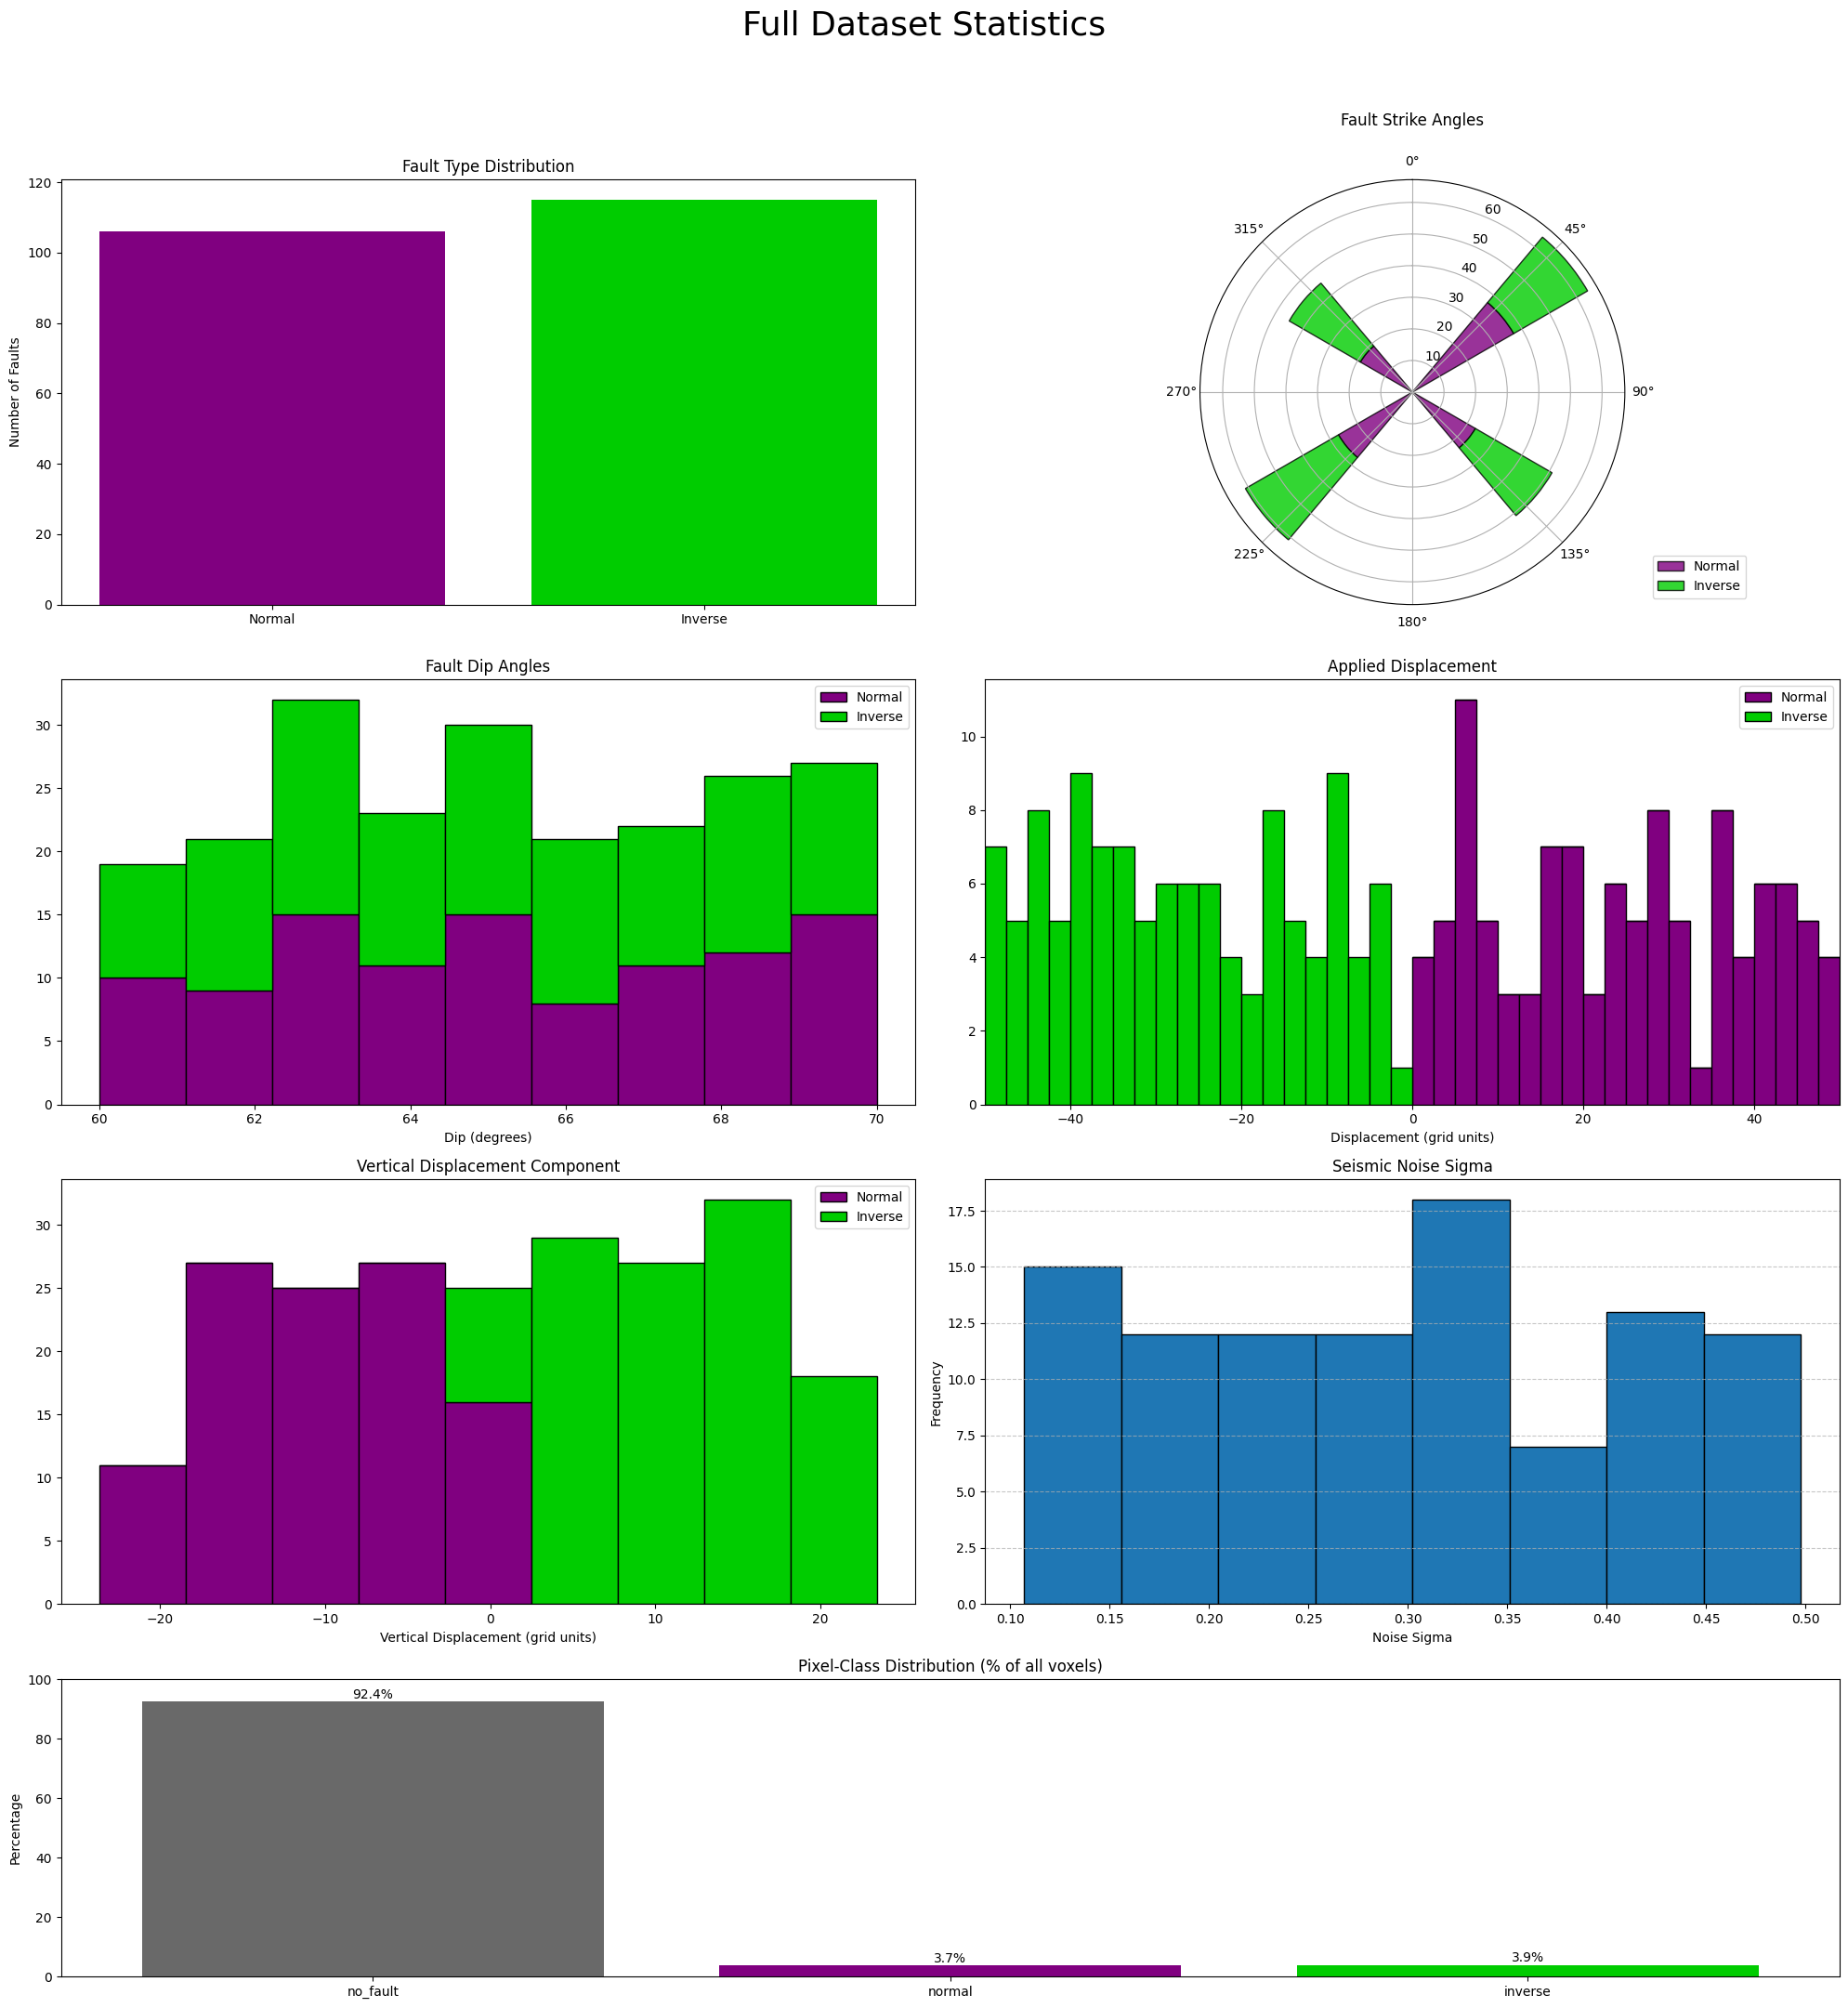


--- Displaying Statistics and Plots for train data ---

Cube Generation Parameter Summary:
             freq  noise_sigma  num_gaussians  num_faults_generated
count  100.000000   100.000000     100.000000            100.000000
mean    59.870912     0.298269       5.500000              2.170000
std      5.449980     0.115874       2.467977              1.435868
min     50.271764     0.107031       2.000000              0.000000
25%     56.023929     0.198982       3.000000              1.000000
50%     60.022818     0.301751       5.000000              2.000000
75%     64.589516     0.400390       7.250000              3.000000
max     69.760821     0.497687      10.000000              4.000000

Pixel-class distribution – OVERALL (% of all voxels):
    no_fault:  92.48 %
      normal:   3.63 %
     inverse:   3.89 %
Pixel-class distribution – MEAN PER CUBE:
    no_fault:  92.29 %
      normal:   3.63 %
     inverse:   3.88 %
Saved figure → /home/roderickperez/DS_PROJECTS/faultSeg/gener

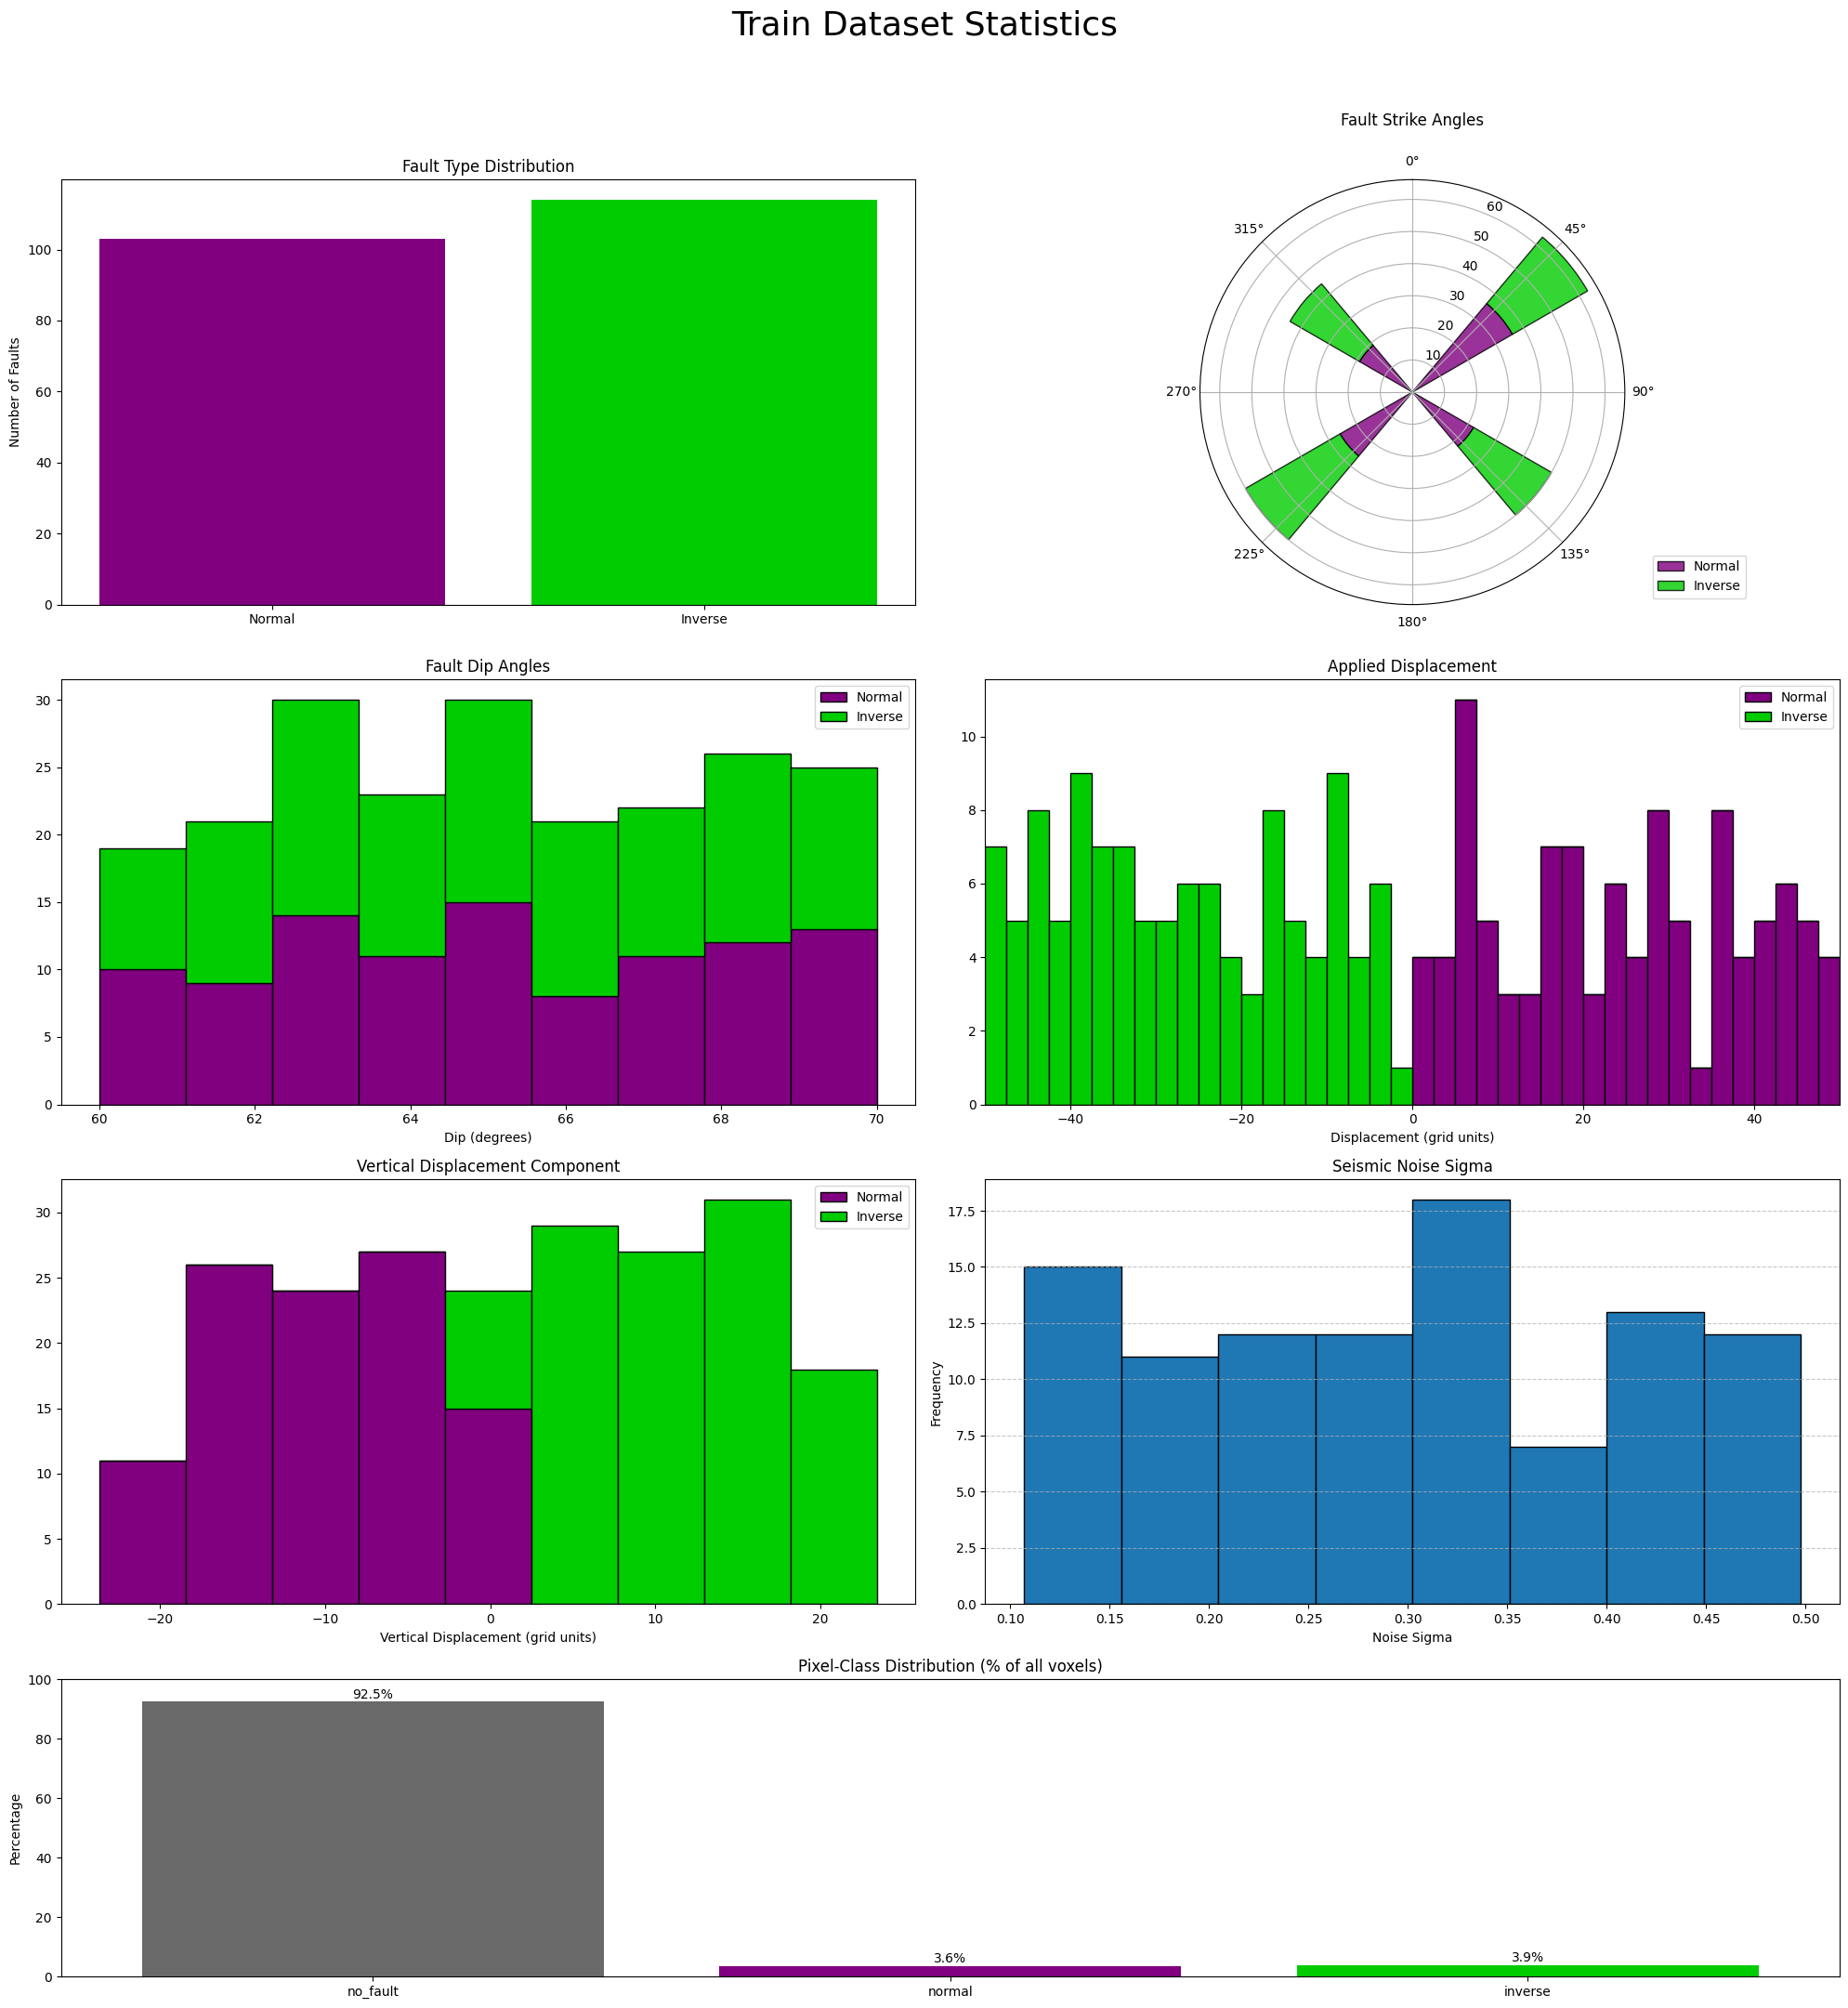


--- Displaying Statistics and Plots for validation data ---

Cube Generation Parameter Summary:
            freq  noise_sigma  num_gaussians  num_faults_generated
count   1.000000     1.000000            1.0                   1.0
mean   66.791397     0.167351            9.0                   4.0
std          NaN          NaN            NaN                   NaN
min    66.791397     0.167351            9.0                   4.0
25%    66.791397     0.167351            9.0                   4.0
50%    66.791397     0.167351            9.0                   4.0
75%    66.791397     0.167351            9.0                   4.0
max    66.791397     0.167351            9.0                   4.0

Pixel-class distribution – OVERALL (% of all voxels):
    no_fault:  83.48 %
      normal:  12.35 %
     inverse:   4.17 %
Pixel-class distribution – MEAN PER CUBE:
    no_fault:  83.12 %
      normal:  12.29 %
     inverse:   4.15 %
Saved figure → /home/roderickperez/DS_PROJECTS/faultSeg/generateS

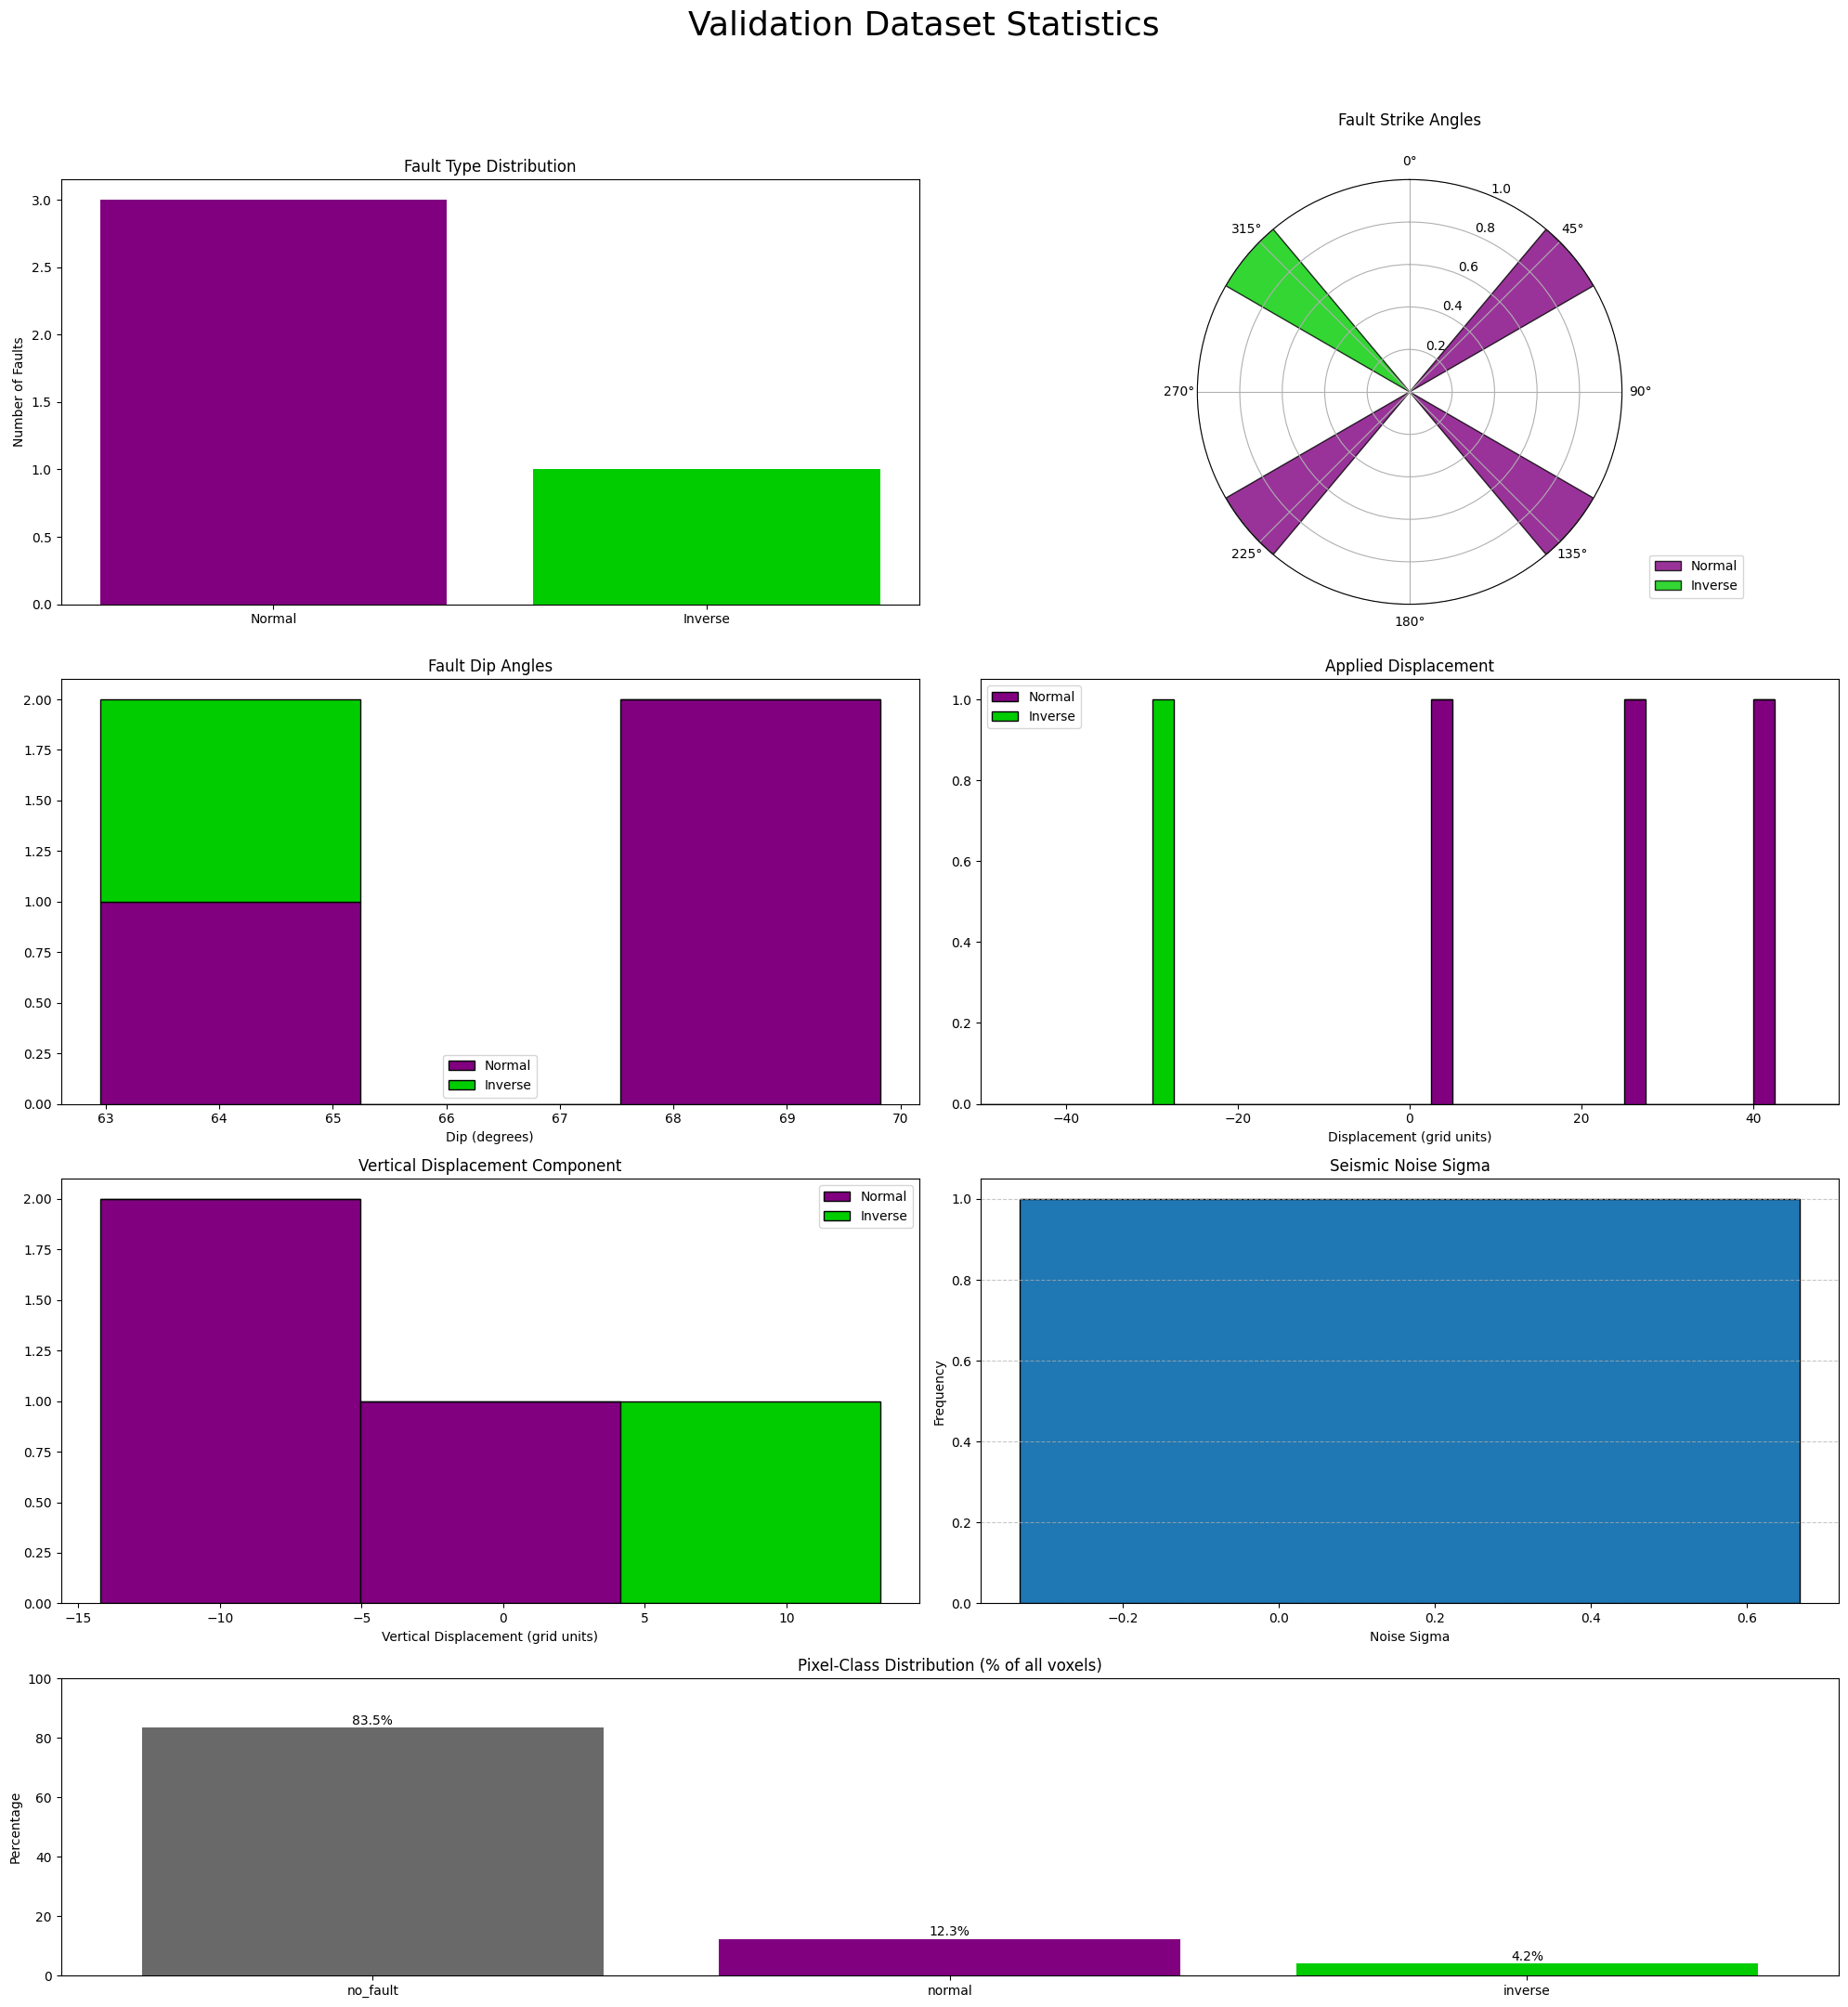

In [19]:


# ─── 3) Display Statistics and Plots for All Splits Individually ──────────────────────────────

# palette for stacked plots
normal_colour  = (0.50, 0.00, 0.50)   # purple  (Normal)
inverse_colour = (0.00, 0.80, 0.00)   # green   (Inverse)
    
for split_name in ['full', 'train', 'validation']:
    stats = all_stats_data.get(split_name)
    print(f"\n--- Displaying Statistics and Plots for {split_name} data ---")

    if not stats or 'cube_level_params' not in stats or 'all_fault_params' not in stats:
        print(f"No statistics available for '{split_name}' split.")
        continue

    # Extract parameters for the current split
    cube_level_params = stats['cube_level_params']
    all_fault_params  = stats['all_fault_params']

    # Create a summary DataFrame
    df = pd.DataFrame(cube_level_params)
    print("\nCube Generation Parameter Summary:")
    print(df.describe())

    # ------------------------------------------------------------------
    # NEW ─ gather all mask cubes for pixel-class statistics
    # ------------------------------------------------------------------
    mask_cubes = []
    splits_to_scan = ['train', 'validation'] if split_name == 'full' else [split_name]
    for split_dir in splits_to_scan:
        mdir = os.path.join(base_out, split_dir, "fault")
        if not os.path.isdir(mdir):
            continue
        for fname in sorted(os.listdir(mdir)):
            if not fname.endswith((".npy", ".dat")):
                continue
            fpath = os.path.join(mdir, fname)
            if fname.endswith(".npy"):
                mask_cubes.append(np.load(fpath))
            else:  # .dat
                mask_cubes.append(np.fromfile(fpath, dtype=np.uint8)
                                  .reshape((cube_size,)*3))

    overall_pct, mean_pct = count_pixels(mask_cubes, mask_mode)

    print("\nPixel-class distribution – OVERALL (% of all voxels):")
    for k, v in overall_pct.items():
        print(f"  {k:>10}: {v:6.2f} %")
    print("Pixel-class distribution – MEAN PER CUBE:")
    for k, v in mean_pct.items():
        print(f"  {k:>10}: {v:6.2f} %")

    # --- Generate and Display Plots ---
    if not all_fault_params:
        print("\nNo fault parameters to plot for this split.")
        continue

    # Extract fault-specific data for plotting
    strikes               = [f['strike'] for f in all_fault_params]
    dips                  = [f['dip'] for f in all_fault_params]
    displacements = [f['applied_disp_signed'] for f in all_fault_params]
    vertical_displacements= [f['vertical_disp_component'] for f in all_fault_params]
    noise_sigmas          = [p.get('noise_sigma')         for p in cube_level_params]

    # Create a figure with a grid of subplots  (NOW 4×2)
    fig = plt.figure(figsize=(20, 22))
    fig.suptitle(f"{split_name.capitalize()} Dataset Statistics", fontsize=26)
    gs = fig.add_gridspec(4, 2, height_ratios=[1, 1, 1, 0.7])

    # Plot Fault Counts
    ax1 = fig.add_subplot(gs[0, 0])

    if mask_mode == 0:
        # binary → one bar
        ax1.bar(['Total'],
                [len(all_fault_params)],
                color=['skyblue'])
    else:
        # multiclass → two bars (Normal, Inverse)
        normal_count  = sum(1 for f in all_fault_params if f['fault_type'] == 'Normal')
        inverse_count = sum(1 for f in all_fault_params if f['fault_type'] == 'Inverse')
        ax1.bar(['Normal', 'Inverse'],
                [normal_count, inverse_count],
                color=[normal_colour, inverse_colour])

    ax1.set_title('Fault Type Distribution')
    ax1.set_ylabel('Number of Faults')

    # Plot Strike Rose Diagram
    ax2 = fig.add_subplot(gs[0, 1], projection='polar')
    if strikes:
        if mask_mode == 1:
            # --- separate angles
            strikes_normal  = np.radians([f['strike'] for f in all_fault_params if f['fault_type'] == 'Normal'])
            strikes_inverse = np.radians([f['strike'] for f in all_fault_params if f['fault_type'] == 'Inverse'])

            num_bins = 18
            bins_rad = np.linspace(0, 2*np.pi, num_bins + 1)
            cnt_norm , _ = np.histogram(strikes_normal , bins=bins_rad)
            cnt_inv  , _ = np.histogram(strikes_inverse, bins=bins_rad)

            centres = bins_rad[:-1] + np.diff(bins_rad)/2
            width   = np.diff(bins_rad)[0]

            # first ring = Normal
            ax2.bar(centres, cnt_norm,
                    width=width,
                    bottom=0.0,
                    color=normal_colour,
                    edgecolor='black',
                    alpha=0.8,
                    label='Normal')
            # stacked on top = Inverse
            ax2.bar(centres, cnt_inv,
                    width=width,
                    bottom=cnt_norm,
                    color=inverse_colour,
                    edgecolor='black',
                    alpha=0.8,
                    label='Inverse')

            ax2.legend(loc='lower left', bbox_to_anchor=(1.05, 0.0))
            ax2.set_title('Fault Strike Angles', va='bottom', y=1.1)
            ax2.set_theta_zero_location("N")  # 0° at North
            ax2.set_theta_direction(-1)       # clockwise

        else:
            # Explicit 0–360° rose (no 180° wrapping)
            angles = np.deg2rad(np.mod(strikes, 360.0))
            num_bins = 18
            bins_rad = np.linspace(0, 2*np.pi, num_bins + 1)
            cnt, _ = np.histogram(angles, bins=bins_rad)

            centres = bins_rad[:-1] + np.diff(bins_rad)/2
            width = np.diff(bins_rad)[0]

            ax2.bar(centres, cnt, width=width, bottom=0.0, edgecolor='black', alpha=0.9)
            ax2.set_title('Fault Strike Angles', va='bottom', y=1.1)
            ax2.set_theta_zero_location("N")  # 0° at North
            ax2.set_theta_direction(-1)       # clockwise


    # Plot Dip Histogram
    ax3 = fig.add_subplot(gs[1, 0])

    if dips:
        if mask_mode == 1:
            dips_normal  = [f['dip'] for f in all_fault_params if f['fault_type'] == 'Normal']
            dips_inverse = [f['dip'] for f in all_fault_params if f['fault_type'] == 'Inverse']
            ax3.hist([dips_normal, dips_inverse],
                     bins='auto',
                     stacked=True,
                     color=[normal_colour, inverse_colour],
                     label=['Normal', 'Inverse'],
                     edgecolor='black')
            ax3.legend()
        else:
            plot_histogram(dips, ax=ax3, title='Fault Dip Angles',
                           xlabel='Dip (degrees)')
        ax3.set_title('Fault Dip Angles')
        ax3.set_xlabel('Dip (degrees)')

    # Plot Displacement Histogram
    ax4 = fig.add_subplot(gs[1, 1])
    if displacements:
        # pull bounds from your notebook variable max_disp
        low, high = (max_disp if isinstance(max_disp, (tuple, list)) and len(max_disp) == 2
                    else (min(displacements), max(displacements)))

        if mask_mode == 1:
            disp_normal  = [f['applied_disp_signed'] for f in all_fault_params if f['fault_type'] == 'Normal']
            disp_inverse = [f['applied_disp_signed'] for f in all_fault_params if f['fault_type'] == 'Inverse']
            ax4.hist([disp_normal, disp_inverse],
                    bins=40, range=(low, high),
                    stacked=True,
                    color=[normal_colour, inverse_colour],
                    label=['Normal', 'Inverse'],
                    edgecolor='black')
            ax4.legend()
        else:
            plot_histogram(
                displacements, ax=ax4,
                title='Applied Displacement',
                xlabel='Displacement (grid units)',
                bins=40,
                xlim=(low, high),           # force axis
                hist_range=(low, high),     # force binning window
                use_percentile=False
            )

        ax4.set_xlim(low, high)
        ax4.set_title('Applied Displacement')
        ax4.set_xlabel('Displacement (grid units)')

    # Plot Vertical Displacement Histogram
    ax5 = fig.add_subplot(gs[2, 0])
    if vertical_displacements:
        if mask_mode == 1:
            vdisp_normal  = [f['vertical_disp_component'] for f in all_fault_params if f['fault_type'] == 'Normal']
            vdisp_inverse = [f['vertical_disp_component'] for f in all_fault_params if f['fault_type'] == 'Inverse']
            ax5.hist([vdisp_normal, vdisp_inverse],
                    bins='auto',
                    stacked=True,
                    color=[normal_colour, inverse_colour],
                    label=['Normal', 'Inverse'],
                    edgecolor='black')
            ax5.legend()
        else:
            plot_histogram(vertical_displacements, ax=ax5,
                        title='Vertical Displacement Component',
                        xlabel='Vertical Displacement (grid units)')
        ax5.set_title('Vertical Displacement Component')
        ax5.set_xlabel('Vertical Displacement (grid units)')

    # Plot Noise Sigma Histogram
    ax6 = fig.add_subplot(gs[2, 1])
    if any(n is not None for n in noise_sigmas):
        plot_histogram([n for n in noise_sigmas if n is not None],
                       ax=ax6, title='Seismic Noise Sigma',
                       xlabel='Noise Sigma')

    # ------------------------------------------------------------------
    # NEW subplot: pixel-class distribution
    # ------------------------------------------------------------------
    ax7 = fig.add_subplot(gs[3, :])
    categories = list(overall_pct.keys())

    if mask_mode == 0:
        colours = ['dimgrey', 'skyblue'][:len(categories)]
    else:
        colour_map = {
            'no_fault': 'dimgrey',
            'normal'  : (0.50, 0.00, 0.50),  # purple
            'inverse' : (0.00, 0.80, 0.00)   # green
        }
        colours = [colour_map[c] for c in categories]

    ax7.bar(categories,
            [overall_pct[k] for k in categories],
            color=colours)
    ax7.set_ylim(0, 100)
    ax7.set_title('Pixel-Class Distribution (% of all voxels)')
    ax7.set_ylabel('Percentage')
    for i, k in enumerate(categories):
        ax7.text(i, overall_pct[k] + 1, f"{overall_pct[k]:.1f}%", ha='center')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    img_path = os.path.join(IMAGE_DIR, f"{split_name}_dataset_stats.png")
    fig.savefig(img_path, dpi=300)
    print(f"Saved figure → {img_path}")
    plt.show()


---

In [20]:
import json
with open('/home/roderickperez/DS_PROJECTS/faultSeg/generateSynthData/statistics/statistics_full.json', 'r') as f:
    stats = json.load(f)
displacements = [f['applied_disp_signed'] for f in stats['all_fault_params']]
print(f"Min displacement: {min(displacements)}, Max displacement: {max(displacements)}")


Min displacement: -49.811991464600816, Max displacement: 49.76448888776399


In [21]:
print(split_name, 
      min(displacements), np.percentile(displacements, [2, 98]), max(displacements))

validation -49.811991464600816 [-49.19650603  47.31972108] 49.76448888776399


In [22]:
# Prepare colormaps for sample slices
bw_cmap             = "gray"
overlay_bw_cmap     = ListedColormap([(0,0,0,0), (1,1,1,1)]) # Transparent to White

mask_color_alone_cmap   = ListedColormap([
    (0.00, 0.00, 0.00, 1.0),  # 0 → black
    (0.50, 0.00, 0.50, 1.0),  # 1 → purple (Normal)
    (0.00, 0.80, 0.00, 1.0)   # 2 → green (Inverse)
])
mask_color_overlay_cmap = ListedColormap([
    (0,0,0,0),           # 0 → transparent
    (0.50,0.00,0.50,1),  # 1 → purple (Normal)
    (0.00,0.80,0.00,1)   # 2 → green (Inverse)
])

# Select colormap depending on mask_mode
if mask_mode == 0:
    mask_alone_cmap_slice   = bw_cmap
    mask_overlay_cmap_slice = overlay_bw_cmap
else:
    mask_alone_cmap_slice   = mask_color_alone_cmap
    mask_overlay_cmap_slice = mask_color_overlay_cmap

# Transparency factor for overlays
overlay_alpha = 1.0

---

---

### 3D Visualization

In [27]:
# Prepare colormaps for sample slices
bw_cmap             = "gray"
overlay_bw_cmap     = ListedColormap([(0,0,0,0), (1,1,1,1)]) # Transparent to White

mask_color_alone_cmap   = ListedColormap([
    (0.00, 0.00, 0.00, 1.0),  # 0 → black
    (0.50, 0.00, 0.50, 1.0),  # 1 → purple (Normal)
    (0.00, 0.80, 0.00, 1.0)   # 2 → green (Inverse)
])
mask_color_overlay_cmap = ListedColormap([
    (0,0,0,0),           # 0 → transparent
    (0.50,0.00,0.50,1),  # 1 → purple (Normal)
    (0.00,0.80,0.00,1)   # 2 → green (Inverse)
])

# Select colormap depending on mask_mode
if mask_mode == 0:
    mask_alone_cmap_slice   = bw_cmap
    mask_overlay_cmap_slice = overlay_bw_cmap
else:
    mask_alone_cmap_slice   = mask_color_alone_cmap
    mask_overlay_cmap_slice = mask_color_overlay_cmap

# Transparency factor for overlays
overlay_alpha = 1.0

In [28]:
# Viewer globals (define before functions)
BASE_OUT   = DATA_DIR           # already set earlier
FMT        = output_format      # "npy" or "dat"
CUBE_SHAPE = (cube_size,)*3     # (ni, nx, nt)

In [41]:
import os
import random
import json
import numpy as np
from ipywidgets import Dropdown, interact

# --- CIGVis viewer (grayscale seismic + red mask, with sliders) ---

# Use already defined variables: BASE_OUT, STATS_DIR, FMT, cube_size

def choose_idx_with_faults(split="train"):
    stats_f = os.path.join(STATS_DIR, f"statistics_{split}.json")
    with open(stats_f, "r") as f:
        s = json.load(f)
    by_cube = {}
    for fp in s["all_fault_params"]:
        by_cube.setdefault(fp["cube_id"], []).append(fp)
    cands = [cid for cid, lst in by_cube.items() if lst]
    if not cands:
        raise RuntimeError(f"No cubes with faults in split={split}")
    return random.choice(cands)

def load_volumes(split, idx, fmt=None, cube_shape=None):
    fmt        = fmt or FMT
    cube_shape = cube_shape or CUBE_SHAPE

    fn    = f"{idx}.{fmt}"
    seis_p = os.path.join(BASE_OUT, split, "seis", fn)
    mask_p = os.path.join(BASE_OUT, split, "fault", fn)

    if not (os.path.exists(seis_p) and os.path.exists(mask_p)):
        raise FileNotFoundError(f"Missing files for cube {idx} in {split}")

    if fmt == "npy":
        seismic = np.load(seis_p).astype(np.float32)
        mask    = np.load(mask_p).astype(np.int32)
    else:  # "dat"
        seismic = np.fromfile(seis_p, np.float32).reshape(cube_shape)
        mask    = np.fromfile(mask_p,  np.uint8 ).reshape(cube_shape).astype(np.int32)

    return seismic, mask

# Select split interactively

split_dropdown = Dropdown(options=['train', 'validation'], value='train', description='Dataset Split:')
def select_and_view(split):
    idx = choose_idx_with_faults(split)
    seismic, mask = load_volumes(split, idx)

    vmin, vmax = np.percentile(seismic, (1, 99))

    # MULTICLASS (0=bg, 1=Normal, 2=Inverse, 3=Overlap optional)
    mask_vis  = mask.astype(np.int32)
    max_label = int(mask_vis.max())

    values = [0, 1, 2] + ([3] if max_label >= 3 else [])
    cols_overlay = [
        (1.0, 1.0, 1.0, 0.0),    # 0 → transparent
        (0.50, 0.00, 0.50, 1.0), # 1 → purple (Normal)
        (0.00, 0.80, 0.00, 1.0)  # 2 → green (Inverse)
    ] + ([(1.00, 0.55, 0.00, 1.0)] if max_label >= 3 else [])  # 3 → orange (Overlap)

    fg_cmap = colormap.custom_disc_cmap(values, cols_overlay)
    fg_cmap = colormap.set_alpha_except_min(fg_cmap, 0.9)

    ni, nx, nt = seismic.shape
    def build_nodes(i, x, t):
        pos = [int(i), int(x), int(t)]
        if hasattr(cgp, "create_overlay"):
            nodes = cgp.create_overlay(
                bg_volume=seismic,
                fg_volume=mask_vis,
                pos=pos,
                bg_clim=[float(vmin), float(vmax)],
                fg_clim=[0, float(max_label)],
                bg_cmap="gray",
                fg_cmap=fg_cmap,
                interpolation="nearest",
                show_cbar=False   # keep this False
            )

            # ⬇️ PASTE THIS BLOCK RIGHT HERE ⬇️
            import plotly.graph_objects as go

            def rgba_to_str(rgba):
                r, g, b, a = rgba
                return f"rgba({int(r*255)}, {int(g*255)}, {int(b*255)}, {a:.3f})"

            n_classes = int(max_label) + 1  # includes background
            plotly_colorscale = []
            if max_label == 0:
                c = rgba_to_str(cols_overlay[0])
                plotly_colorscale = [[0.0, c], [1.0, c]]
            else:
                for i_cls in range(n_classes):
                    c = rgba_to_str(cols_overlay[i_cls])
                    lo = i_cls / max_label
                    hi = (i_cls + 1) / max_label if i_cls < max_label else 1.0
                    plotly_colorscale.append([lo, c])
                    plotly_colorscale.append([hi, c])

            tickvals = list(range(n_classes))  # [0,1,2,(3)]
            ticktext = ["Background", "Normal", "Inverse", "Overlap"][:n_classes]

            cbar_trace = go.Scatter3d(
                x=[None], y=[None], z=[None], mode='markers',
                marker=dict(
                    colorscale=plotly_colorscale,
                    cmin=0, cmax=float(max_label),
                    showscale=True,
                    colorbar=dict(
                        title="Mask class",
                        tickmode="array",
                        tickvals=tickvals,
                        ticktext=ticktext,
                        ticks="outside",
                        thickness=15,
                    ),
                ),
                showlegend=False,
            )
            nodes.append(cbar_trace)
            # ⬆️ END PASTED BLOCK ⬆️

        else:
            nodes  = cgp.create_slices(seismic, pos=pos, clim=[float(vmin), float(vmax)],
                                    cmap="gray", show_cbar=False)
            nodes += cgp.create_slices(mask_vis, pos=pos, clim=[0, float(max_label)],
                                    cmap=fg_cmap, interpolation="nearest", show_cbar=False)
        return nodes



    w_i = IntSlider(min=0, max=ni-1, step=1, value=ni//2, description="Inline",   continuous_update=True)
    w_x = IntSlider(min=0, max=nx-1, step=1, value=nx//2, description="Xline",    continuous_update=True)
    w_t = IntSlider(min=0, max=nt-1, step=1, value=nt//2, description="Time",     continuous_update=True)

    def step(slider, d):
        slider.value = max(slider.min, min(slider.max, slider.value + d))

    btn_i_minus = Button(description="Inline −"); btn_i_minus.on_click(lambda _: step(w_i, -1))
    btn_i_plus  = Button(description="Inline +"); btn_i_plus .on_click(lambda _: step(w_i, +1))
    btn_x_minus = Button(description="Xline −");  btn_x_minus.on_click(lambda _: step(w_x, -1))
    btn_x_plus  = Button(description="Xline +");  btn_x_plus .on_click(lambda _: step(w_x, +1))
    btn_t_minus = Button(description="Time −");   btn_t_minus.on_click(lambda _: step(w_t, -1))
    btn_t_plus  = Button(description="Time +");   btn_t_plus .on_click(lambda _: step(w_t, +1))

    play = Play(interval=60, value=w_t.value, min=w_t.min, max=w_t.max, step=1, description="▶")
    jslink((play, 'value'), (w_t, 'value'))

    def update(i, x, t):
        nodes = build_nodes(i, x, t)
        cgp.plot3D(nodes)

    out = interactive_output(update, {"i": w_i, "x": w_x, "t": w_t})
    display(VBox([
        HBox([w_i, btn_i_minus, btn_i_plus]),
        HBox([w_x, btn_x_minus, btn_x_plus]),
        HBox([w_t, btn_t_minus, btn_t_plus, play]),
        out
    ]))
    print(f"Viewing split='{split}', cube id={idx}")

interact(select_and_view, split=split_dropdown)


interactive(children=(Dropdown(description='Dataset Split:', options=('train', 'validation'), value='train'), …

<function __main__.select_and_view(split)>